In [74]:
import pandas as pd
import torch
from torchvision import transforms
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels_fn =  "data1/path_and_kpts1.csv"
kpts_frame = pd.read_csv(labels_fn)

In [3]:
img_name = kpts_frame.iloc[:, 1]
kpts = kpts_frame.iloc[:, 2:]


In [57]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    new_img = image.permute([1,2,0])
    plt.imshow(new_img.int())
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [75]:
class TantrixLandmarksDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.landmarks_frame.iloc[idx, 1]
        image = io.imread(img_name)
        #print(image.shape)
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
#         #print(image.shape)
        if self.transform:
            image = self.transform(image)
        landmarks = self.landmarks_frame.iloc[idx, 2:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': torch.from_numpy(landmarks)} # torch.from_numpy(image), torch.from_numpy(landmarks)

        

        return sample

In [76]:
#from other file:
std = 59.27295119572318
mean = 111.47896697185168 

trans = transforms.Normalize((mean, mean, mean), (std, std, std), inplace=False)

tantrix_DS = TantrixLandmarksDataset(labels_fn, transform = trans)

In [77]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/std, 1/std, 1/std ]),
                                transforms.Normalize(mean = [ -mean, -mean, -mean ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [60]:
for i in range(5):
    print(tantrix_DS.landmarks_frame.iloc[i, 1])

/run/media/mah904/Porsche/tantrix-data/data1/0.jpg
/run/media/mah904/Porsche/tantrix-data/data1/1.jpg
/run/media/mah904/Porsche/tantrix-data/data1/2.jpg
/run/media/mah904/Porsche/tantrix-data/data1/3.jpg
/run/media/mah904/Porsche/tantrix-data/data1/4.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.880773
0 torch.Size([3, 300, 300]) torch.Size([8, 2])


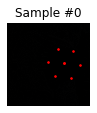

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.880773
1 torch.Size([3, 300, 300]) torch.Size([8, 2])


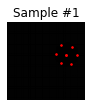

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.880773
2 torch.Size([3, 300, 300]) torch.Size([8, 2])


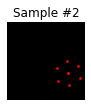

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-1.880773
3 torch.Size([3, 300, 300]) torch.Size([8, 2])


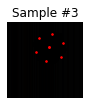

In [69]:
for i in range(len(tantrix_DS)):
    offset = 0#len(tantrix_DS)-5
    sample = tantrix_DS[i+len(tantrix_DS)-5]
    print(np.array(sample['image']).min())
    print(i+offset, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    if i == 3:
        plt.show()
        break

In [45]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [33]:
dataloader = torch.utils.data.DataLoader(tantrix_DS, batch_size=4,
                        shuffle=True, num_workers=4)

In [34]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #300x300
        self.conv1 = nn.Conv2d(3, 32, 5)
        #300-5+1 = 296
        self.pool1 = nn.MaxPool2d(2, 2, ceil_mode = True)
        #296/2 = 135
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        #135-3+1 = 132
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode = True)
        #132/2 = 66
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        #66-3+1 = 64
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode = True)
        #64/2 = 32
        
        self.conv4 = nn.Conv2d(128, 512, 3)
        #32-3+1 = 30
        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode = True)
        #30/2 = 15
        
        self.fc1 = nn.Linear(512 * 17 ** 2, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 16)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = x.view(-1, 512 * 17 ** 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [153]:
net.parameters
net.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc1): Linear(in_features=147968, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
)

In [154]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [156]:

PRINT_EVERY = 50
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        [inputs, labels] = data.values()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.float().cuda())
        outputs = outputs.view((4, 8, 2))
        loss = criterion(outputs, labels.type(torch.float).cuda())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % PRINT_EVERY == 0 and i:    # print every PRINT_EVERY mini-batches
#             print(loss)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / PRINT_EVERY))
            running_loss = 0.0

print('Finished Training')

[1,    51] loss: 801.719
[1,   101] loss: 843.328
[1,   151] loss: 841.633
[1,   201] loss: 815.112
[1,   251] loss: 914.393
[1,   301] loss: 823.129
[1,   351] loss: 793.653
[1,   401] loss: 859.115
[1,   451] loss: 873.430
[1,   501] loss: 799.374
[1,   551] loss: 796.487
[1,   601] loss: 837.292
[1,   651] loss: 863.556
[1,   701] loss: 897.142
[1,   751] loss: 870.159
[1,   801] loss: 895.797
[1,   851] loss: 941.474
[1,   901] loss: 831.184
[1,   951] loss: 840.743
[1,  1001] loss: 842.895
[1,  1051] loss: 844.386
[1,  1101] loss: 837.567
[1,  1151] loss: 793.853
[1,  1201] loss: 811.358
[2,    51] loss: 873.090
[2,   101] loss: 797.362
[2,   151] loss: 841.662
[2,   201] loss: 879.182
[2,   251] loss: 865.427
[2,   301] loss: 803.532
[2,   351] loss: 805.288
[2,   401] loss: 831.648
[2,   451] loss: 836.981
[2,   501] loss: 831.482
[2,   551] loss: 859.006
[2,   601] loss: 781.916
[2,   651] loss: 817.958
[2,   701] loss: 805.642
[2,   751] loss: 810.934
[2,   801] loss: 833.738


KeyboardInterrupt: 

In [159]:
torch.save(net.state_dict(), "adamNet.pth")

In [35]:
anothernet = Net()

In [36]:
anothernet.load_state_dict(torch.load("adamNet.pth"))

<All keys matched successfully>

In [37]:
anothernet.cuda()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (fc1): Linear(in_features=147968, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=16, bias=True)
)

In [104]:
sample = tantrix_DS[np.random.randint(len(tantrix_DS))]

In [105]:
sample = tantrix_DS[np.random.randint(len(tantrix_DS))]
input_img = sample["image"].unsqueeze(0) 
output = anothernet(input_img.cuda())
output

tensor([[181.2203, 164.7660, 186.2937, 154.8410, 184.7155, 147.5093, 185.9471,
         150.4079, 195.7985, 156.8878, 187.7143, 152.6451, 184.4084, 154.5447,
         185.9396, 163.1890]], device='cuda:0', grad_fn=<AddmmBackward>)

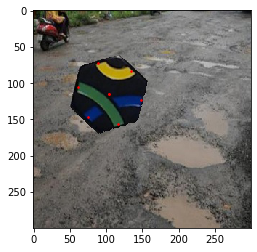

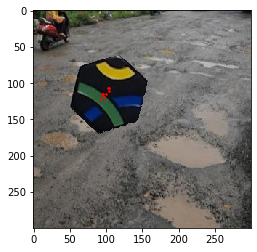

In [129]:
sample = tantrix_DS[np.random.randint(len(tantrix_DS))]
input_img = sample["image"].unsqueeze(0) 
output = anothernet(input_img.cuda())
ouy=output.detach().cpu()
inv = invTrans(sample["image"])
landmarks_output = ouy.view((8, 2))
show_landmarks(inv, sample["landmarks"])
show_landmarks(inv, landmarks_output)

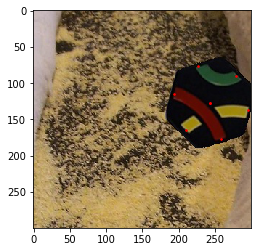

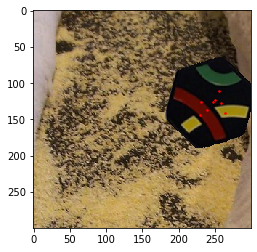

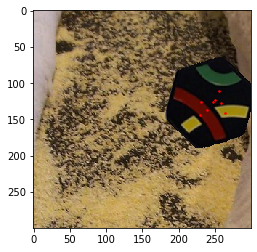

In [111]:
inv = invTrans(sample["image"])
show_landmarks(inv, landmarks_output)